In [1]:
import numpy as np
import pandas as pd 
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns

Total Data : 54338
Bukan Dewasa : 27192
Dewasa : 27146


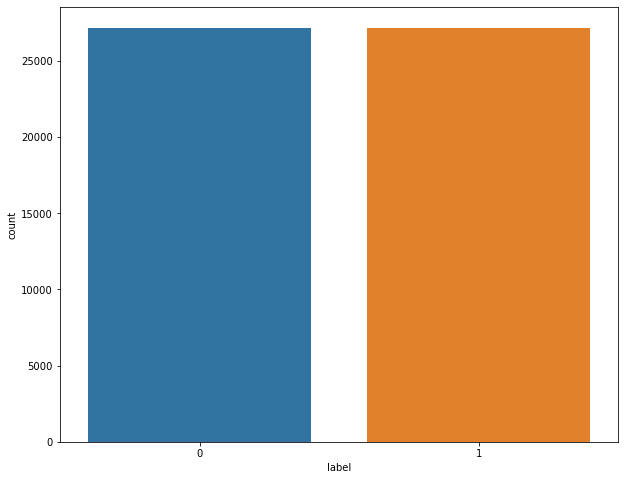

In [2]:
data = pd.read_excel("data/label/combineSSL1.xlsx")
data.replace('', np.nan, inplace=True)
data.dropna(inplace=True) # memastikan tidak ada nilai yang kosong
dewasa = data.loc[data['label'] == 1, 'tweet'].copy().reset_index(drop=True)
bukan = data.loc[data['label'] == 0, 'tweet'].copy().reset_index(drop=True)
print("Total Data :", len(data))
print("Bukan Dewasa :", len(bukan))
print("Dewasa :", len(dewasa))

plt.figure(figsize=(10,8))
sns.countplot(x='label', data=data)
plt.show()

In [3]:
# Splitting Data
text = data['tweet'].values
label = data['label'].values
data_train, data_test, label_train, label_test = train_test_split(text, label, test_size=0.33, random_state=42)
data_train, data_val, label_train, label_val = train_test_split(data_train, label_train, test_size= 0.33, random_state=42)

In [4]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

vocab = max([len(tokenizer.word_index)]) + 1 # kamus kata 
maxlen = max([len(i.split()) for i in text]) # panjang input sequence
batch_size = 64 # penentuan jumlah sample yang ditraining pada tiap epoch
num_epochs = 20 # banyak iterasi pada saat training model 
initializer = initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=2)

In [5]:
#Data Train
X_train = tokenizer.texts_to_sequences(data_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = to_categorical(label_train, num_classes = 2)

#Data Test
X_test = tokenizer.texts_to_sequences(data_test)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_test = to_categorical(label_test, num_classes = 2)

#Data Validation
X_val = tokenizer.texts_to_sequences(data_val)
X_val = pad_sequences(X_val, maxlen=maxlen)
Y_val = to_categorical(label_val, num_classes = 2)

In [6]:
def get_model1(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 32, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Bidirectional(LSTM(32, recurrent_initializer = initializer, kernel_initializer = initializer)))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def get_model2(X, Y):
    model = Sequential() 
    model.add(Embedding(input_dim = vocab, output_dim = 128, input_length = maxlen, embeddings_initializer = initializer))
    model.add(Bidirectional(LSTM(128, recurrent_initializer = initializer, kernel_initializer = initializer)))
    model.add(Dense(2, activation='sigmoid', kernel_initializer = initializer)) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.xlim([0,max(history.epoch)])
        
def evaluation(model, X, Y):
    # Predict the values
    Y_pred = model.predict(X)
    Y_pred_class = np.argmax(Y_pred, axis=1)
    Y_act = Y
    # accuracy
    accuracy = accuracy_score(Y_act, Y_pred_class)
    print("Accuracy: %.2f" % (accuracy*100), "%")
    # precision
    precision = precision_score(Y_act, Y_pred_class)
    print("Precision: %.2f" % (precision*100), "%")
    # recall
    recall = recall_score(Y_act, Y_pred_class)
    print("Recall: %.2f" % (recall*100), "%")
    
    return Y_act, Y_pred_class

def conf_matrix(Y_act, Y_pred):
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_act, Y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt="d");
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Model 1

In [7]:
model1 = get_model1(X_train, Y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 58, 32)            1325248   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 1,342,018
Trainable params: 1,342,018
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# training model
history1 = model1.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/20
382/382 [==============================] - 28s 37ms/step - loss: 0.5092 - accuracy: 0.7227 - val_loss: 0.0801 - val_accuracy: 0.9810
Epoch 2/20
382/382 [==============================] - 13s 35ms/step - loss: 0.0531 - accuracy: 0.9865 - val_loss: 0.0608 - val_accuracy: 0.9833
Epoch 3/20
382/382 [==============================] - 14s 36ms/step - loss: 0.0240 - accuracy: 0.9937 - val_loss: 0.0649 - val_accuracy: 0.9818
Epoch 4/20
382/382 [==============================] - 14s 38ms/step - loss: 0.0114 - accuracy: 0.9975 - val_loss: 0.0723 - val_accuracy: 0.9813
Epoch 5/20
382/382 [==============================] - 14s 37ms/step - loss: 0.0082 - accuracy: 0.9985 - val_loss: 0.0874 - val_accuracy: 0.9773
Epoch 6/20
382/382 [==============================] - 14s 36ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0875 - val_accuracy: 0.9799
Epoch 7/20
382/382 [==============================] - 14s 37ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.0927 - val_accuracy:

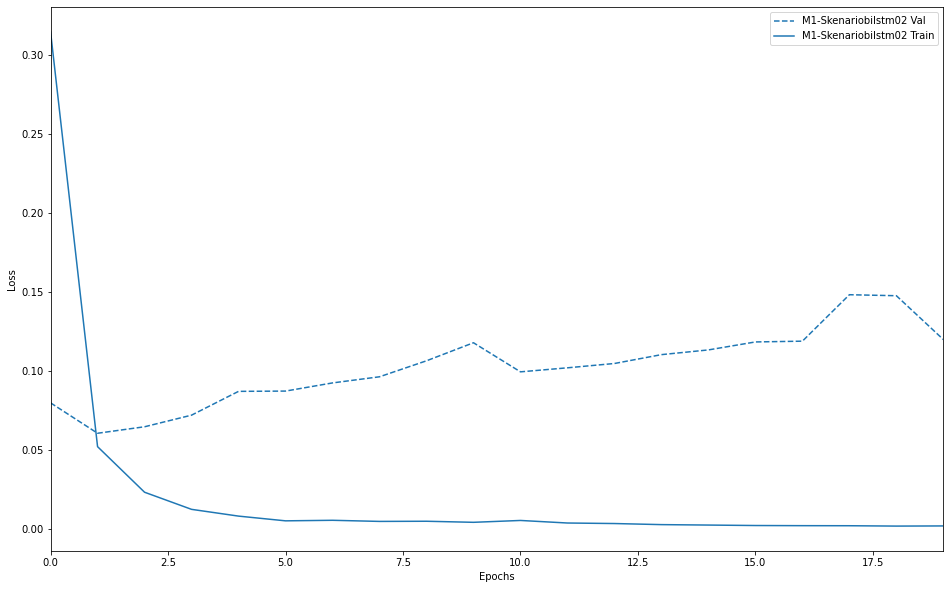

In [9]:
plot_history([('M1-SkenarioBiLSTM02', history1)])

# Evaluasi 1

Evaluasi Data Test
Accuracy: 97.74 %
Precision: 97.99 %
Recall: 97.40 %


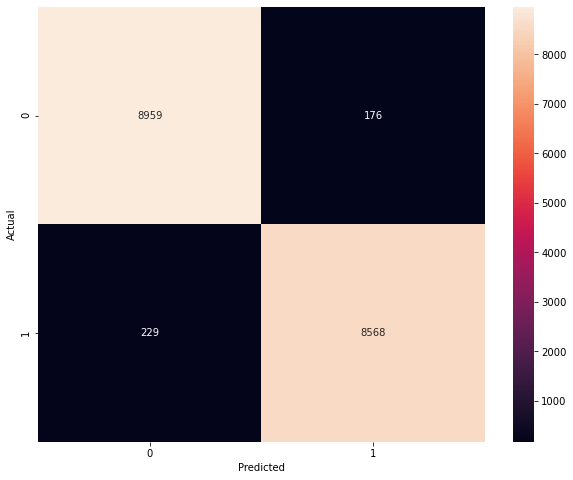

In [10]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model1, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.95 %
Precision: 99.98 %
Recall: 99.92 %


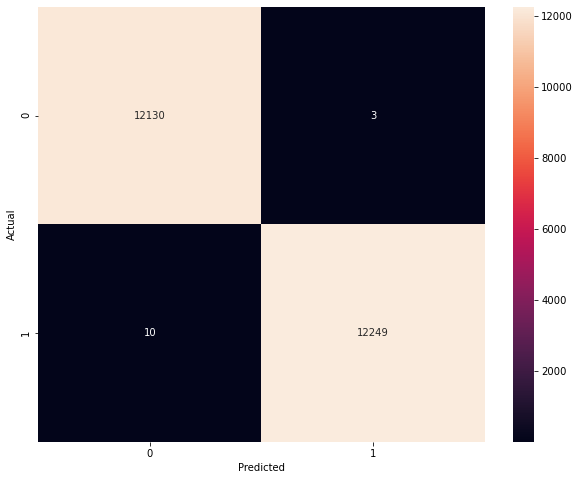

In [11]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model1, X_train, label_train)
conf_matrix(Y_act, Y_pred)

# Model 2

In [12]:
model2 = get_model2(X_train, Y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 58, 128)           5300992   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 5,564,674
Trainable params: 5,564,674
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
# training model
history2 = model2.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/20
382/382 [==============================] - 64s 160ms/step - loss: 0.3950 - accuracy: 0.7981 - val_loss: 0.0647 - val_accuracy: 0.9844
Epoch 2/20
382/382 [==============================] - 62s 162ms/step - loss: 0.0408 - accuracy: 0.9890 - val_loss: 0.0700 - val_accuracy: 0.9804
Epoch 3/20
382/382 [==============================] - 62s 162ms/step - loss: 0.0179 - accuracy: 0.9951 - val_loss: 0.0637 - val_accuracy: 0.9826
Epoch 4/20
382/382 [==============================] - 62s 163ms/step - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.0721 - val_accuracy: 0.9828
Epoch 5/20
382/382 [==============================] - 64s 167ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0836 - val_accuracy: 0.9817
Epoch 6/20
382/382 [==============================] - 73s 190ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0853 - val_accuracy: 0.9834
Epoch 7/20
382/382 [==============================] - 71s 187ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.1040 - val_ac

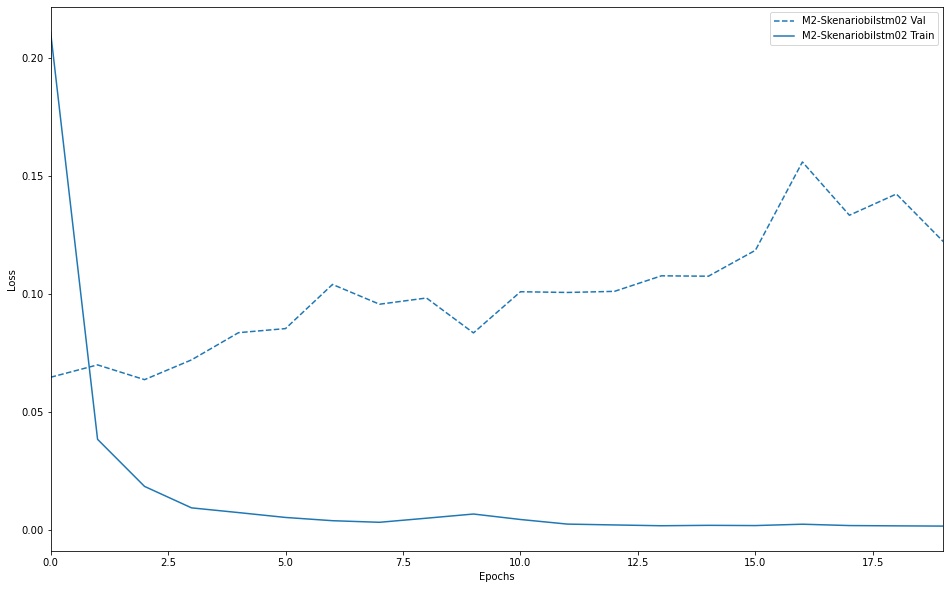

In [14]:
plot_history([('M2-SkenarioBiLSTM02', history2)])

# Evaluasi 2

Evaluasi Data Test
Accuracy: 98.26 %
Precision: 98.07 %
Recall: 98.39 %


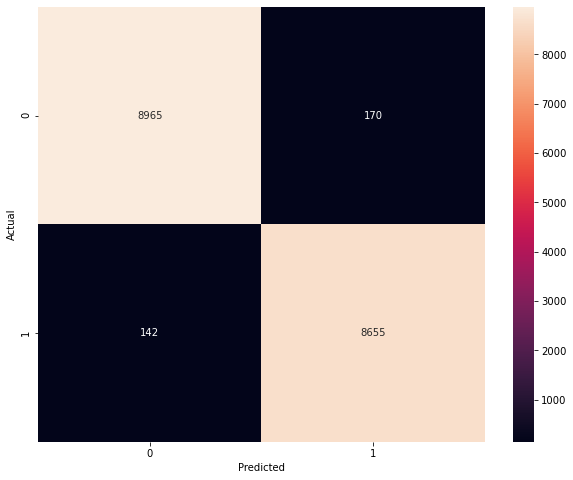

In [15]:
print("Evaluasi Data Test")
Y_act, Y_pred = evaluation(model2, X_test, label_test)
conf_matrix(Y_act, Y_pred)

Evaluasi Data Train
Accuracy: 99.95 %
Precision: 99.97 %
Recall: 99.93 %


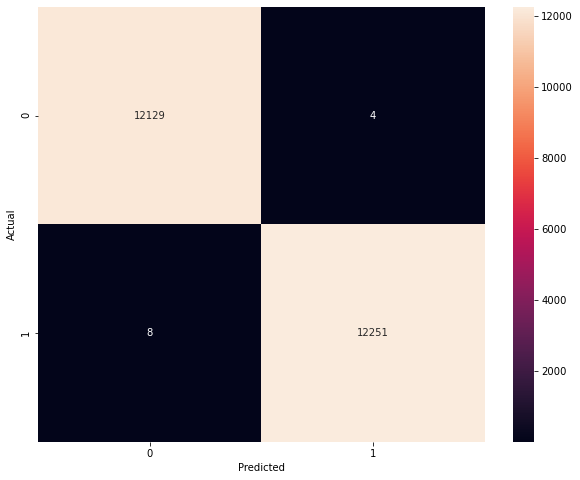

In [16]:
print("Evaluasi Data Train")
Y_act, Y_pred = evaluation(model2, X_train, label_train)
conf_matrix(Y_act, Y_pred)

# Grafik Keseluruhan 

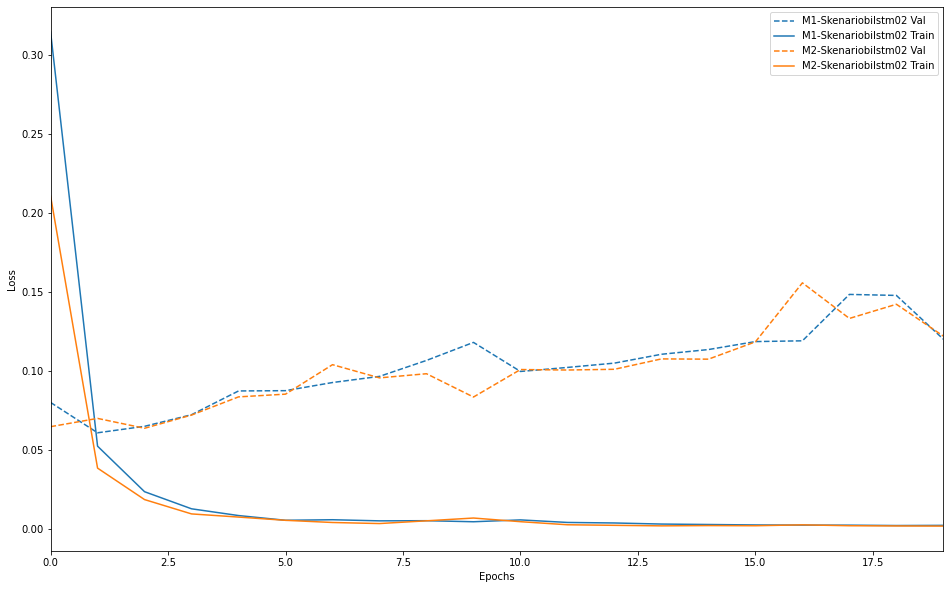

In [17]:
plot_history([('M1-SkenarioBiLSTM02', history1),
              ('M2-SkenarioBiLSTM02', history2)])

# Save Model

In [18]:
model1.save('model/M1-SkenarioBiLSTM02.h5')
model2.save('model/M2-SkenarioBiLSTM02.h5')